## Limpieza de los datos

### Importación BBDD de MySQL

In [48]:
# instalacion de libreria para hacer la conexión con SQL Alchemy:
#pip install SQLAlchemy

In [49]:
# Conectar con MySQL usando SQLAlchemy
from sqlalchemy import create_engine
import pandas as pd

# Detalles de la conexión a la base de datos
host = '212.227.90.6'
database = 'Equip_10'
user = 'Equipo10'
password = 'E1q2u3i4p5o10'

# Crear la cadena de conexión para SQLAlchemy
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

try:
    # Conectar a la base de datos
    connection = engine.connect()
    print("Conectado al servidor MySQL usando SQLAlchemy")

    # Cargar la tabla tourist_accommodation usando pandas y SQLAlchemy
    df = pd.read_sql_table('Tourist_Accommodation', connection)
    print(f"Tabla 'Tourist_Accommodation' cargada en el DataFrame: df_tourist.")

except Exception as e:
    print(f"Error al conectar o leer la tabla: {e}")

finally:
    # Cerrar la conexión
    if 'connection' in locals() and connection:
        connection.close()
        print("Conexión cerrada")

Conectado al servidor MySQL usando SQLAlchemy
Tabla 'Tourist_Accommodation' cargada en el DataFrame: df_tourist.
Conexión cerrada


### Eliminación de casos duplicados en la FK 'apartment_id': 

Creación de un df que solo contenga los casos duplicados para poderlos examinar

In [50]:
# Suponiendo que tu DataFrame se llama 'df'
df_duplicados = df[df.duplicated(subset=['apartment_id'], keep=False)].copy()

Para la eliminación de los casos duplicados en 'apartment_id' hemos usado la variable 'insert_date' quedandonos con la fecha más moderna y eliminando el resto de registros repetidos.

In [51]:
# Transformar la variable temporal a datetime especificando el formato
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')

# Ordena el DataFrame por 'apartment_id' y luego por 'insert_date' de forma descendente
df_ordenado = df.sort_values(by=['apartment_id', 'insert_date'], ascending=[True, False])

# Elimina los duplicados de 'apartment_id', quedándonos con el primero (el más reciente por el ordenamiento)
df_sin_duplicados = df_ordenado.drop_duplicates(subset=['apartment_id'], keep='first').copy()

# Si quieres resetear el índice del DataFrame resultante
df_sin_duplicados = df_sin_duplicados.reset_index(drop=True)

print(f"Tamaño del DataFrame original: {len(df)}")
print(f"Tamaño del DataFrame sin duplicados: {len(df_sin_duplicados)}")

Tamaño del DataFrame original: 7001
Tamaño del DataFrame sin duplicados: 6733


### Eliminación de datos nulls y transformación de variables:

#### Transformación de variables temporales:

In [52]:
# Convertir las variables temporales a datetime:
df_sin_duplicados['first_review_date'] = pd.to_datetime(df_sin_duplicados['first_review_date'], format='%d/%m/%Y')
df_sin_duplicados['last_review_date'] = pd.to_datetime(df_sin_duplicados['last_review_date'], format='%d/%m/%Y')

#### Transformación las variables 'bathrooms','bedrooms' y 'beds'
- Para poder poner las variables con el formato adecuado primero se ha hacer un tratamiendo de los datos nulls.
- Se ha imputado el valor de la mediana de los nulls usando otras variables como referencia para crear grupos homogeneos.

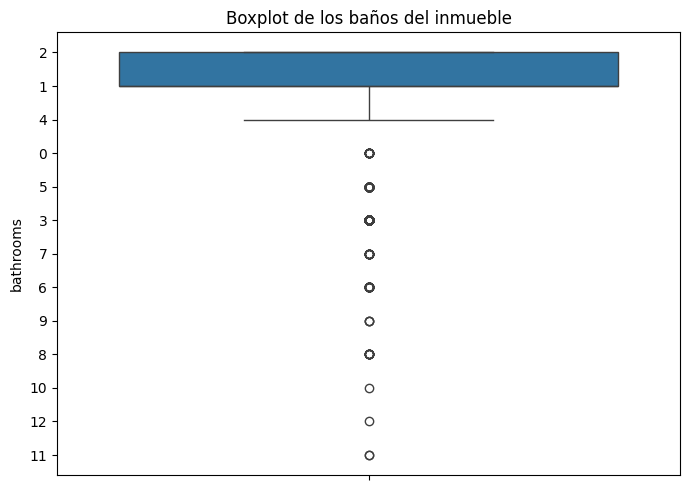

In [53]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['bathrooms'])
plt.xticks(rotation=45)
plt.title('Boxplot de los baños del inmueble')
plt.tight_layout()
plt.show()

In [54]:
import numpy as np

# Primero, convierte la columna 'bathrooms' a numérico, los errores se convierten a NaN
df_sin_duplicados['bathrooms'] = pd.to_numeric(df_sin_duplicados['bathrooms'], errors='coerce')

# Calcula la mediana de 'bathrooms' por cada número de 'accommodates'
mediana_bathrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['bathrooms'].median()

# Imputa los valores nulos en 'bathrooms' usando la mediana correspondiente al número de 'accommodates'
def imputar_bathrooms(row):
    if pd.isnull(row['bathrooms']):
        return mediana_bathrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['bathrooms'].median()) # Si no hay mediana para ese 'accommodates', usa la mediana general
    return row['bathrooms']

df_sin_duplicados['bathrooms'] = df_sin_duplicados.apply(imputar_bathrooms, axis=1)

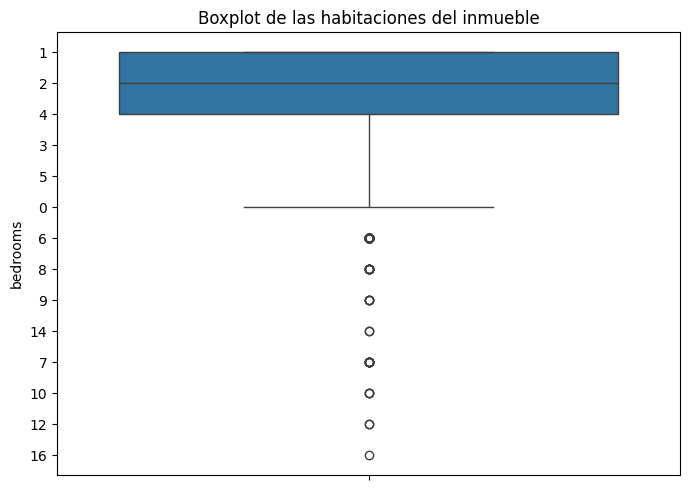

In [55]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['bedrooms'])
plt.xticks(rotation=45)
plt.title('Boxplot de las habitaciones del inmueble')
plt.tight_layout()
plt.show()

In [56]:
# Convertir la columna 'bedrooms' a numérico
df_sin_duplicados['bedrooms'] = pd.to_numeric(df_sin_duplicados['bedrooms'], errors='coerce')

# Calcular la mediana de 'bedrooms' por cada número de 'accommodates'
mediana_bedrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['bedrooms'].median()

# Imputar los valores nulos en 'bedrooms'
def imputar_bedrooms(row):
    if pd.isnull(row['bedrooms']):
        return mediana_bedrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['bedrooms'].median())
    return row['bedrooms']

df_sin_duplicados['bedrooms'] = df_sin_duplicados.apply(imputar_bedrooms, axis=1)

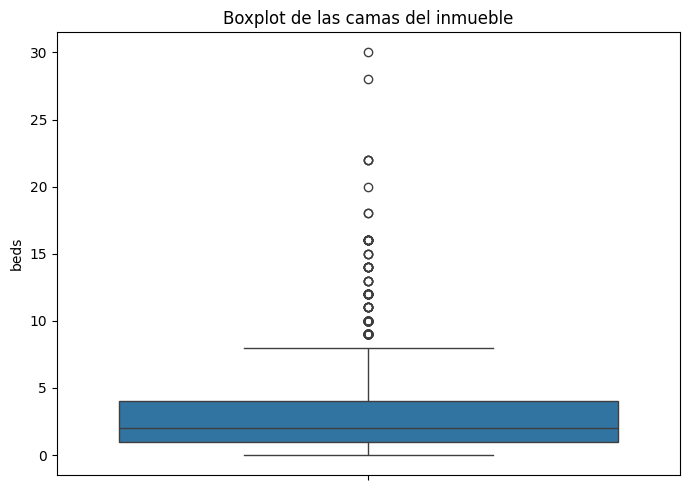

In [57]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['beds'])
plt.xticks(rotation=45)
plt.title('Boxplot de las camas del inmueble')
plt.tight_layout()
plt.show()

In [58]:
# Calcular la mediana de 'beds' por cada número de 'accommodates'
mediana_bedrooms_por_accommodates = df_sin_duplicados.groupby('accommodates')['beds'].median()

# Imputar los valores nulos en 'beds'
def imputar_bedrooms(row):
    if pd.isnull(row['beds']):
        return mediana_bedrooms_por_accommodates.get(row['accommodates'], df_sin_duplicados['beds'].median())
    return row['beds']

df_sin_duplicados['beds'] = df_sin_duplicados.apply(imputar_bedrooms, axis=1)

Para poder imputar en la variable 'price' un valor a los datos nulls se han usado las variables 'room_type' y 'city' para calcular la mediana de cada grupo y a esos grupos donde falta price se le ha aplicado la mediana que corresponde

### Imputación de valores en la variable 'price'

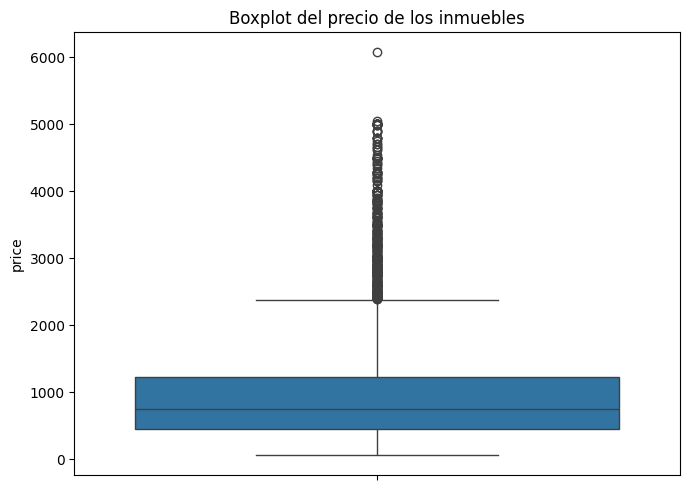

In [59]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados['price'])
plt.xticks(rotation=45)
plt.title('Boxplot del precio de los inmuebles')
plt.tight_layout()
plt.show()

In [60]:
# Calcular la mediana de 'price' por 'city' y 'room_type'
mediana_price_por_city_roomtype = df_sin_duplicados.groupby(['city', 'room_type'])['price'].median()

# Función para imputar los valores nulos en 'price'
def imputar_price(row):
    if pd.isnull(row['price']):
        try:
            return mediana_price_por_city_roomtype[(row['city'], row['room_type'])]
        except KeyError:
            return df_sin_duplicados['price'].median() # Si no existe la combinación, usa la mediana general
    return row['price']

# Aplicar la imputación
df_sin_duplicados['price'] = df_sin_duplicados.apply(imputar_price, axis=1)

### Imputación de valores nulls en las variables score
 - La variable 'review_scores_rating' está en una escala diferente a las otras variables, así que he igualado su escala a la de las otras variables. Solo ejecutar el código 1 vez si no la escala se hace más pequeña que el resto. 
 - Esta variable es la de puntuación global. 

In [61]:
# Dividir entre 10 para ponerla en la misma escala que las otras variables
df_sin_duplicados['review_scores_rating'] = df_sin_duplicados['review_scores_rating'] / 10

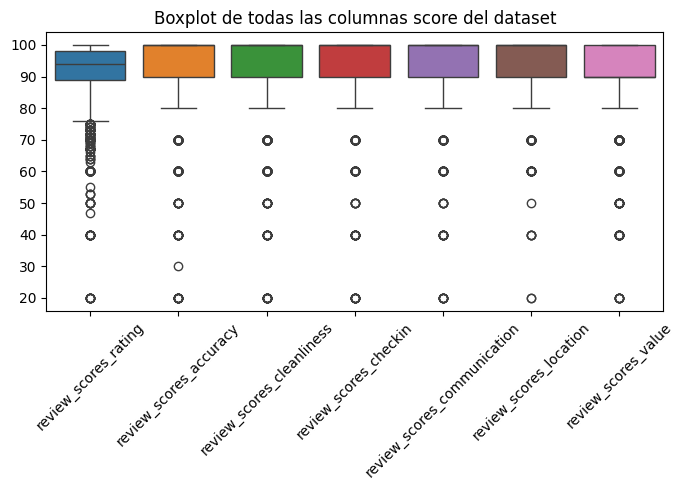

In [62]:
import matplotlib.pyplot as plt    
import seaborn as sns  

# Grafico boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_sin_duplicados.iloc[:, 23:30])
plt.xticks(rotation=45)
plt.title('Boxplot de todas las columnas score del dataset')
plt.tight_layout()
plt.show()

In [63]:
columnas_a_imputar = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                       'review_scores_value', 'reviews_per_month']

for columna in columnas_a_imputar:
    # Imputar con la mediana del grupo
    df_sin_duplicados[columna] = df_sin_duplicados.groupby(['city', 'room_type'])[columna].transform(lambda x: x.fillna(x.median()))
    # Imputar los nulos restantes con la mediana de la columna completa
    mediana_global = df_sin_duplicados[columna].median()
    df_sin_duplicados[columna] = df_sin_duplicados[columna].fillna(mediana_global)

# Verificar la cantidad de nulos después de la imputación
print(df_sin_duplicados[columnas_a_imputar].isnull().sum())

review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
dtype: int64


### Transformación variable has_availability todos los casos verdadero:

Hemos sustitudo 534 valores nulls imputandoles el valor True y hemos transformado el valor VERDADERO en True

In [64]:
# Transformar VERDADERO a True
df_sin_duplicados['has_availability'] = df_sin_duplicados['has_availability'].replace('VERDADERO', True)

# Imputacion a valores nulls por True
df_sin_duplicados['has_availability'].fillna(True, inplace=True)

### Datos nulls que siguen existiendo en el dataset:

In [65]:
# 1. Identificar filas con al menos un valor nulo:
df_sin_duplicados[df_sin_duplicados.isnull().any(axis=1)]

# 2. Obtener el número de valores nulos por columna y filtrar las que tienen al menos uno:
nulos_por_columna = df_sin_duplicados.isnull().sum()

# 3. Eliminar las variables que no tienen nulls de la visualizacion:
columnas_con_nulos = nulos_por_columna[nulos_por_columna > 0]
print("\nNúmero de valores nulos por columna (solo las que tienen nulos):")
print(columnas_con_nulos)


Número de valores nulos por columna (solo las que tienen nulos):
name                         3
description                 27
neighbourhood_district    2658
amenities_list              16
first_review_date         1203
last_review_date          1204
dtype: int64


### Transformación nombre dataset para crear archivo .csv y poder importar el documento en PowerBi

In [66]:
# Cambio del nombre del dataset
df_tourist = df_sin_duplicados

# Exportar el nuevo df como .csv
nombre_archivo_csv = 'df_tourist.csv'
df_tourist.to_csv(nombre_archivo_csv, index=False, encoding='utf-8')

# Mensaje sobre la operación realizada
print(f"El DataFrame se ha guardado exitosamente en '{nombre_archivo_csv}'")

El DataFrame se ha guardado exitosamente en 'df_tourist.csv'


importamos librerias:

In [67]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
from scipy.stats import shapiro
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd


Inspeccionamos DF

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7001 entries, 0 to 7000
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7001 non-null   int64         
 1   name                         6998 non-null   object        
 2   description                  6972 non-null   object        
 3   host_id                      7001 non-null   int64         
 4   neighbourhood_name           7001 non-null   object        
 5   neighbourhood_district       4241 non-null   object        
 6   room_type                    7001 non-null   object        
 7   accommodates                 7001 non-null   int64         
 8   bathrooms                    6969 non-null   object        
 9   bedrooms                     6972 non-null   object        
 10  beds                         6998 non-null   float64       
 11  amenities_list               6984 non-null 

In [69]:
df.describe().round(2)

,apartment_id,host_id,accommodates,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,insert_date
count,7001.00,7.001000e+03,7001.00,6998.00,6870.00,7001.00,7001.00,7001.00,7001.00,7001.00,...,7001.00,5674.00,5665.00,5671.0,5660.00,5669.00,5659.00,5659.00,5747.00,7001
mean,15119780.99,6.218673e+07,4.35,3.01,1011.10,4.42,759.47,12.28,27.42,44.31,...,34.13,920.23,94.54,93.2,96.29,96.43,95.31,91.46,123.04,2019-04-19 14:26:57.711755520
min,11964.00,1.070400e+04,1.00,0.00,60.00,1.00,1.00,0.00,0.00,0.00,...,0.00,200.00,20.00,20.0,20.00,20.00,20.00,20.00,1.00,2017-01-04 00:00:00
25%,8749646.00,1.050015e+07,2.00,1.00,450.00,1.00,70.00,0.00,2.00,9.00,...,1.00,890.00,90.00,90.0,90.00,90.00,90.00,90.00,17.00,2018-08-14 00:00:00
50%,16737061.00,4.261380e+07,4.00,2.00,750.00,2.00,1125.00,10.00,26.00,46.00,...,9.00,940.00,100.00,100.0,100.00,100.00,100.00,90.00,57.00,2019-04-24 00:00:00
75%,21463214.00,1.062896e+08,6.00,4.00,1230.00,4.00,1125.00,24.00,50.00,76.00,...,40.00,980.00,100.00,100.0,100.00,100.00,100.00,100.00,177.00,2020-02-16 00:00:00
max,27245117.00,3.365242e+08,29.00,30.00,6071.00,365.00,1125.00,30.00,60.00,90.00,...,588.00,1000.00,100.00,100.0,100.00,100.00,100.00,100.00,1291.00,2021-02-27 00:00:00
std,7715577.75,5.747094e+07,2.62,2.33,845.98,10.67,497.96,11.51,22.41,33.02,...,59.94,85.35,9.06,9.7,7.96,7.61,7.30,9.31,153.16,NaN


### Variabilidad/distribución variable precio:

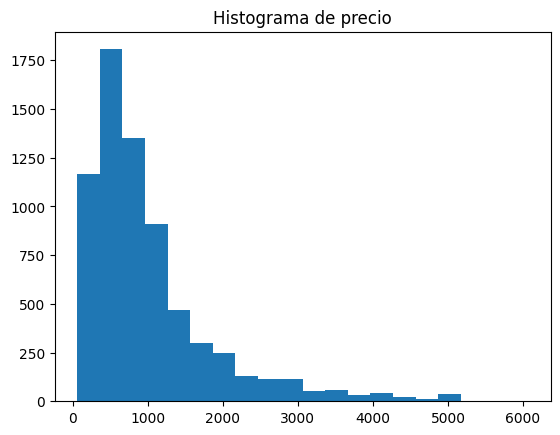

In [70]:
# Ajustamos la escala del eje Y para mostrar números completos ( sin notación cientifica por default)
plt.ticklabel_format(style='plain', axis='y')


plt.title('Histograma de precio')
plt.hist(df['price'], bins=20)
plt.show()

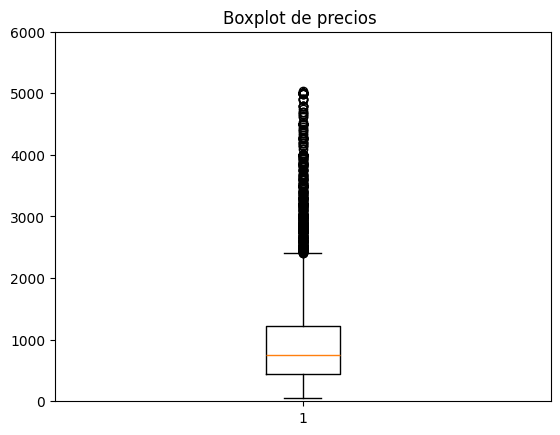

In [71]:
plt.boxplot(df['price'].dropna()) # quitamos los nan para evitar anomalias 
plt.ylim(0, 6000)  # Ajustamos los límites según los valores del dataset
plt.title('Boxplot de precios ')
plt.show()


### Limpieza de datos utilizando el IQR

Identificación/tratamiento de Outliers:

In [72]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para considerar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame para mantener solo los valores dentro de los límites
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

Volvemos a graficar la variable trás el tratamiento de los Outliers


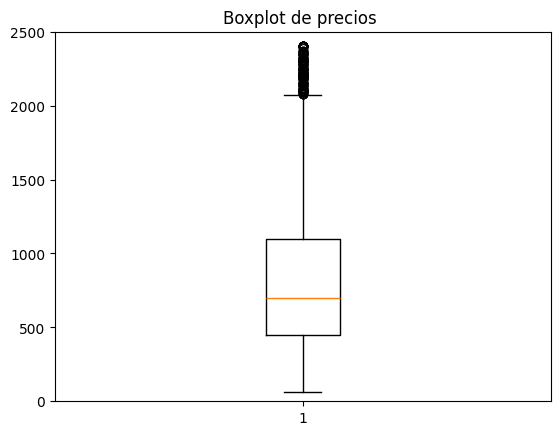

In [73]:
plt.boxplot(df_filtered['price'].dropna()) # quitamos los nan para evitar anomalias 
plt.ylim(0, 2500)  # Ajustamos los límites según los valores del dataset
plt.title('Boxplot de precios ')
plt.show()

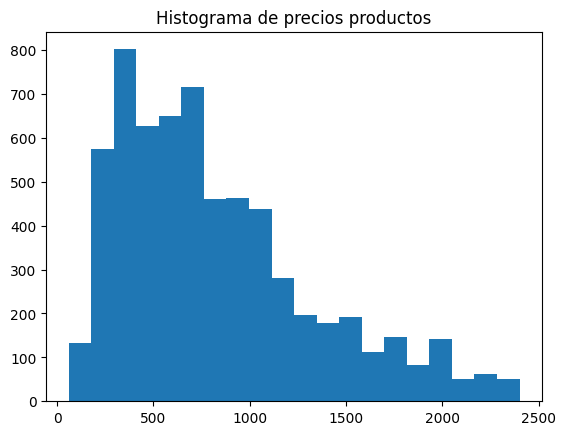

In [74]:
# Ajustamos la escala del eje Y para mostrar números completos ( sin notación cientifica por default)
plt.ticklabel_format(style='plain', axis='y')


# Histograma 
plt.title('Histograma de precios productos')
plt.hist(df_filtered['price'], bins=20)
plt.show()

In [75]:
df_filtered['price'].describe().round(2)

count    6361.00
mean      824.39
std       505.43
min        60.00
25%       450.00
50%       700.00
75%      1100.00
max      2400.00
Name: price, dtype: float64

In [76]:
df[['price']].var().round(2)

price    715674.34
dtype: float64

Verificamos dispersión de la variable price

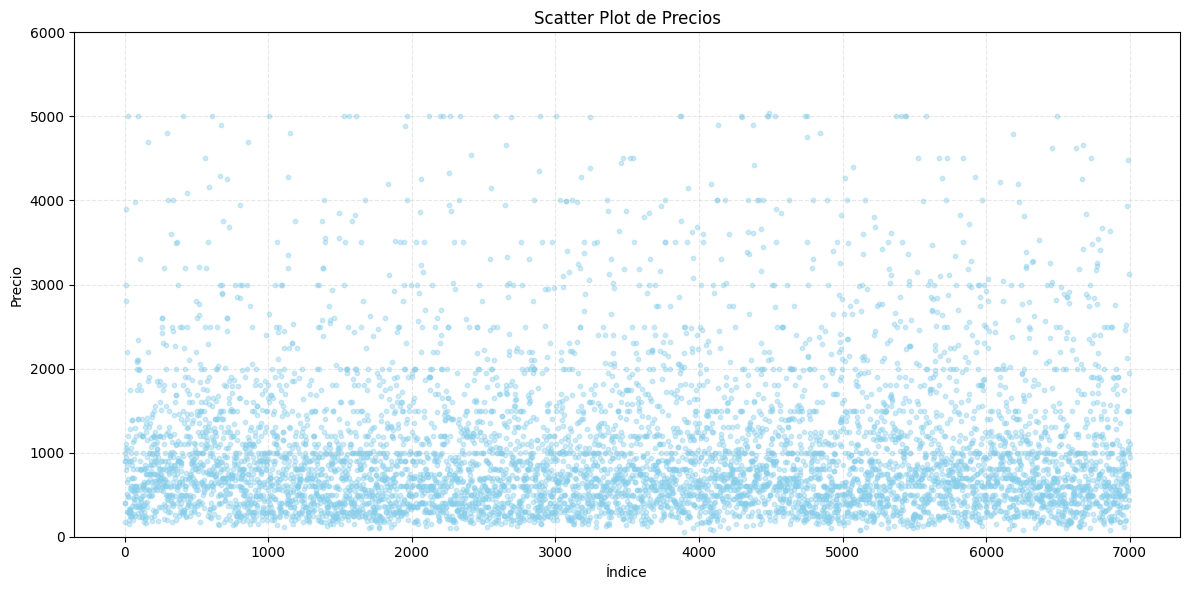

In [77]:
# Eliminamos los NaN
price_nonan = df['price'].dropna()

plt.figure(figsize=(12, 6))
plt.scatter(price_nonan.index, price_nonan, alpha=0.4, color='skyblue', s=10)
plt.ylim(0, 6000)
plt.title('Scatter Plot de Precios')
plt.xlabel('Índice')
plt.ylabel('Precio')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### Boxplot availability 

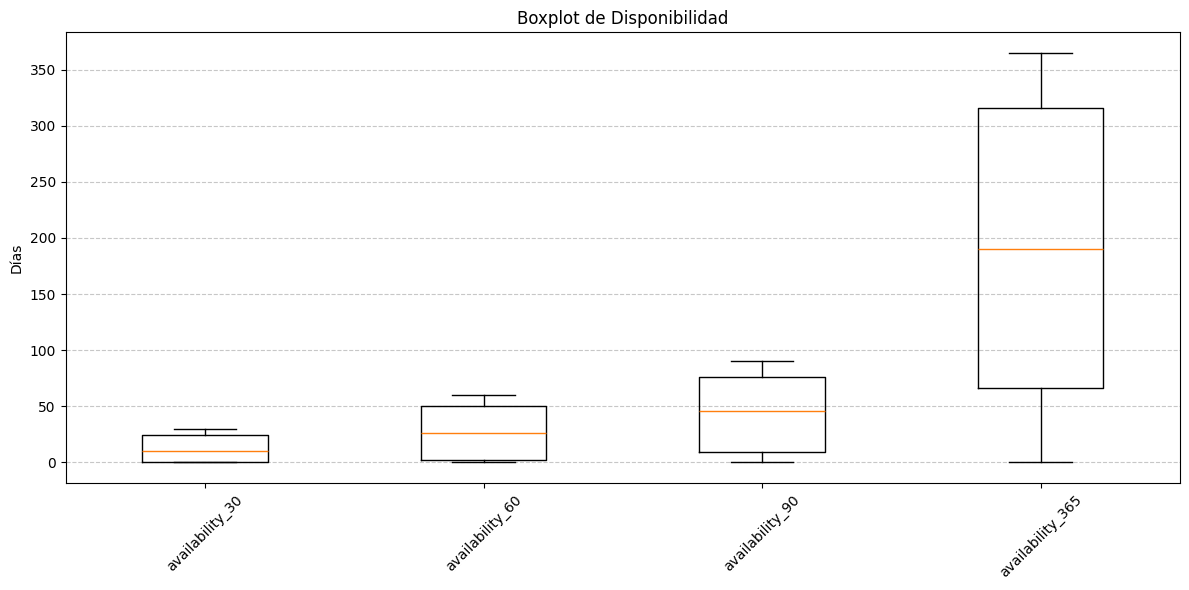

In [78]:
# Lista de variables
variables = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

# Crear el boxplot
plt.figure(figsize=(12, 6))
plt.boxplot([df[var].dropna() for var in variables], labels=variables)
plt.title('Boxplot de Disponibilidad')
plt.ylabel('Días')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## EDA Usuarios

In [79]:
df_tourist

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,None,Private room,2,2.0,1.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,75.0,spain,malaga,2018-07-31
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,C�rmenes,Latina,Private room,1,1.0,1.0,...,90.0,100.0,100.0,80.0,90.0,FALSO,52.0,spain,madrid,2020-01-10
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1.0,2.0,...,100.0,100.0,100.0,100.0,100.0,VERDADERO,142.0,spain,sevilla,2019-07-29
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2.0,1.0,...,90.0,100.0,100.0,100.0,90.0,VERDADERO,306.0,spain,barcelona,2020-01-10
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,None,Private room,5,1.0,2.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,39.0,spain,girona,2019-02-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,27237828,Studio at Finca Els Olivers,"Independent guest house, forming part of an ex...",1323233,B�scara,None,Entire home/apt,2,1.0,1.0,...,100.0,100.0,100.0,100.0,100.0,FALSO,10.0,spain,girona,2018-08-30
6729,27241318,ES MOLI D'EN SION - Villa with private pool in...,Enjoy the peace of the countryside in this bea...,80839530,Sa Pobla,None,Entire home/apt,10,4.0,5.0,...,100.0,100.0,100.0,100.0,100.0,VERDADERO,7.0,spain,mallorca,2020-04-23
6730,27244243,101.108_New building apartment with two double...,Apartment in Cadaqu�s center. 1rst �floor. Ele...,151496825,Cadaqu�s,None,Entire home/apt,4,1.0,2.0,...,100.0,100.0,100.0,100.0,90.0,VERDADERO,24.0,spain,girona,2018-08-30
6731,27244794,101.38_Apartment with one doble bedroom and te...,101.38.- Apartment placed Sa T�rtora � Sant An...,151496825,Cadaqu�s,None,Entire home/apt,2,1.0,1.0,...,100.0,100.0,100.0,100.0,100.0,VERDADERO,6.0,spain,girona,2019-12-31


### Creación dataset Usuarios:

In [80]:
# # Versión completa dataset Usuarios:
# df_us = df_tourist[['apartment_id','host_id','city','room_type','accommodates','bathrooms','bedrooms','beds','price','last_review_date','number_of_reviews',
#             'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
#             'review_scores_location','review_scores_value','is_instant_bookable','reviews_per_month','insert_date']]

# df_us

In [81]:
df_us = df_tourist[['apartment_id','host_id','city','room_type','accommodates','bathrooms','bedrooms','beds','price','number_of_reviews','last_review_date',
            'review_scores_rating','reviews_per_month','insert_date']]

df_us

,apartment_id,host_id,city,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,last_review_date,review_scores_rating,reviews_per_month,insert_date
0,11964,45553,malaga,Private room,2,2.0,1.0,1.0,400.0,78,2017-09-05,97.0,75.0,2018-07-31
1,21853,83531,madrid,Private room,1,1.0,1.0,1.0,170.0,33,2018-07-15,92.0,52.0,2020-01-10
2,32347,139939,sevilla,Entire home/apt,4,1.0,2.0,2.0,990.0,148,2019-07-22,98.0,142.0,2019-07-29
3,35379,152232,barcelona,Private room,2,2.0,1.0,1.0,400.0,292,2020-01-04,94.0,306.0,2020-01-10
4,35801,153805,girona,Private room,5,1.0,2.0,5.0,900.0,36,2018-08-08,97.0,39.0,2019-02-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,27237828,1323233,girona,Entire home/apt,2,1.0,1.0,1.0,1500.0,1,2018-08-26,100.0,10.0,2018-08-30
6729,27241318,80839530,mallorca,Entire home/apt,10,4.0,5.0,7.0,3130.0,1,2020-03-13,100.0,7.0,2020-04-23
6730,27244243,151496825,girona,Entire home/apt,4,1.0,2.0,2.0,990.0,0,NaT,94.0,24.0,2018-08-30
6731,27244794,151496825,girona,Entire home/apt,2,1.0,1.0,2.0,720.0,1,2018-09-23,100.0,6.0,2019-12-31


### Reorganización del dataset y creación de nuevas columnas (mes, año, trimestre)

In [82]:
# Creación nuevas columnas temporales
df_us['month'] = df_us['insert_date'].dt.month  
df_us['month_name'] = df_us['insert_date'].dt.month_name()  
df_us['quarter'] = df_us['insert_date'].dt.quarter  
df_us['year'] = df_us['insert_date'].dt.year  

In [83]:
df_us

,apartment_id,host_id,city,room_type,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,last_review_date,review_scores_rating,reviews_per_month,insert_date,month,month_name,quarter,year
0,11964,45553,malaga,Private room,2,2.0,1.0,1.0,400.0,78,2017-09-05,97.0,75.0,2018-07-31,7,July,3,2018
1,21853,83531,madrid,Private room,1,1.0,1.0,1.0,170.0,33,2018-07-15,92.0,52.0,2020-01-10,1,January,1,2020
2,32347,139939,sevilla,Entire home/apt,4,1.0,2.0,2.0,990.0,148,2019-07-22,98.0,142.0,2019-07-29,7,July,3,2019
3,35379,152232,barcelona,Private room,2,2.0,1.0,1.0,400.0,292,2020-01-04,94.0,306.0,2020-01-10,1,January,1,2020
4,35801,153805,girona,Private room,5,1.0,2.0,5.0,900.0,36,2018-08-08,97.0,39.0,2019-02-19,2,February,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,27237828,1323233,girona,Entire home/apt,2,1.0,1.0,1.0,1500.0,1,2018-08-26,100.0,10.0,2018-08-30,8,August,3,2018
6729,27241318,80839530,mallorca,Entire home/apt,10,4.0,5.0,7.0,3130.0,1,2020-03-13,100.0,7.0,2020-04-23,4,April,2,2020
6730,27244243,151496825,girona,Entire home/apt,4,1.0,2.0,2.0,990.0,0,NaT,94.0,24.0,2018-08-30,8,August,3,2018
6731,27244794,151496825,girona,Entire home/apt,2,1.0,1.0,2.0,720.0,1,2018-09-23,100.0,6.0,2019-12-31,12,December,4,2019


In [84]:
df_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6733 entries, 0 to 6732
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   apartment_id          6733 non-null   int64         
 1   host_id               6733 non-null   int64         
 2   city                  6733 non-null   object        
 3   room_type             6733 non-null   object        
 4   accommodates          6733 non-null   int64         
 5   bathrooms             6733 non-null   float64       
 6   bedrooms              6733 non-null   float64       
 7   beds                  6733 non-null   float64       
 8   price                 6733 non-null   float64       
 9   number_of_reviews     6733 non-null   int64         
 10  last_review_date      5529 non-null   datetime64[ns]
 11  review_scores_rating  6733 non-null   float64       
 12  reviews_per_month     6733 non-null   float64       
 13  insert_date       

In [85]:
# Describe filtrado
descripcion = df_us.describe().round(2)
descripcion_filtrada = descripcion.iloc[:, 2:9]

descripcion_filtrada

,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,last_review_date
count,6733.00,6733.00,6733.00,6733.00,6733.00,6733.00,5529
mean,4.35,1.60,1.96,3.01,1012.03,34.17,2018-10-24 21:46:54.758545920
min,1.00,0.00,0.00,0.00,60.00,0.00,2012-11-17 00:00:00
25%,2.00,1.00,1.00,1.00,460.00,1.00,2018-02-25 00:00:00
50%,4.00,1.00,2.00,2.00,750.00,9.00,2018-10-28 00:00:00
75%,6.00,2.00,3.00,4.00,1250.00,40.00,2019-09-09 00:00:00
max,29.00,12.00,16.00,30.00,6071.00,588.00,2021-02-13 00:00:00
std,2.63,0.99,1.30,2.34,838.64,60.21,NaN


### Visualizaciones de algunas variables:

Boxplot e Histogramas de la variable accommodates

In [113]:
import plotly.express as px

fig = px.box(df_us, y='review_scores_rating', title='Boxplot puntuación de los alojamientos')
fig.update_layout(yaxis_title='Puntuación', width=600, height=400)
fig.show()

In [121]:
import plotly.express as px

fig = px.histogram(df_us, x='review_scores_rating',
                   title='Histograma de puntuación de los alojamientos',
                   labels={'review_scores_rating': 'Puntuación de los alojamientos'})

fig.update_layout(yaxis_title_text='Frecuencia')
fig.update_layout(width=600, height=400)

fig.show()

Distribución por tipo de alojamientos

In [122]:
import plotly.graph_objects as go
import pandas as pd

# Suponiendo que df_us ya está definido

if 'room_type' in df_us.columns:
    room_type_counts = df_us['room_type'].value_counts().reset_index()
    room_type_counts.columns = ['room_type', 'count']
    order = room_type_counts['room_type'].tolist()
    room_types = room_type_counts['room_type'].unique()
    colors = [px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] for i in range(len(room_types))]
    color_map = dict(zip(room_types, colors))

    data = []
    for rt in room_types:
        count = room_type_counts[room_type_counts['room_type'] == rt]['count'].iloc[0]
        data.append(go.Bar(x=[rt], y=[count], marker_color=color_map[rt], name=rt))

    fig = go.Figure(data=data)

    fig.update_layout(title='Distribución por tipo de alojamiento',
                      xaxis_title='Tipo de alojamiento',
                      yaxis_title='Frecuencia',
                      xaxis={'categoryorder': 'array', 'categoryarray': order})

    fig.update_xaxes(tickangle=45)
    fig.update_layout(width=600, height=400)
    
    fig.show()
else:
    print("La columna 'room_type' no se encuentra en el DataFrame df_us.")

Boxplots de numero de Camas, Dormitorios y Baños

In [123]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Suponiendo que df_us ya está definido
variables_ingles = ['beds', 'bedrooms', 'bathrooms']
variables_espanol = ['Camas', 'Habitaciones', 'Baños']

fig = make_subplots(rows=1, cols=3, subplot_titles=variables_espanol)

for i, var_ingles in enumerate(variables_ingles):
    var_espanol = variables_espanol[i]
    fig.add_trace(go.Box(y=df_us[var_ingles], name=var_espanol), row=1, col=i+1)

fig.update_layout(title_text='Distribución de Número de Camas, Habitaciones y Baños')
fig.update_yaxes(title_text='Cantidad', row=1, col=1)
fig.update_yaxes(title_text='Cantidad', row=1, col=2)
fig.update_yaxes(title_text='Cantidad', row=1, col=3)

fig.update_layout(width=600, height=400)

fig.show()

Histogramas de Camas, Dormitorios y Baños

In [127]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Suponiendo que df_us ya está definido
variables = ['beds', 'bedrooms', 'bathrooms']
colors = ['green', 'orange', 'red']
titles = ['Camas', 'Dormitorios', 'Baños']

fig = make_subplots(rows=1, cols=3, subplot_titles=[f'Histograma de {title}' for title in titles])

for i, var in enumerate(variables):
    fig.add_trace(go.Histogram(x=df_us[var], nbinsx=30, marker_color=colors[i], opacity=0.7, name=titles[i]),
                  row=1, col=i+1)

fig.update_layout(title_text='Histogramas de Camas, Dormitorios y Baños')
fig.update_xaxes(title_text='Unidades', row=1)
fig.update_yaxes(title_text='Frecuencia', row=1)

fig.update_layout(width=1200, height=400)

fig.show()

Comparación room_types con 'accommodates', 'beds', 'bathrooms','bedrooms'

In [131]:
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Variables numéricas a comparar
num_vars = ['accommodates', 'beds', 'bathrooms','bedrooms']

# Obtener el orden de room_type y los room_types únicos
if 'df_us' in locals() and 'room_type' in df_us.columns:
    room_type_order = df_us['room_type'].value_counts().index.tolist()
    all_room_types = df_us['room_type'].unique()
elif 'df_us' in locals() and 'room_type' in df_us.columns:
    room_type_order = df_us['room_type'].value_counts().index.tolist()
    all_room_types = df_us['room_type'].unique()
else:
    print("La columna 'room_type' no se encuentra en los DataFrames disponibles.")
    exit()

# Definir un mapa de colores consistente para cada room_type
color_map = {rt: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
             for i, rt in enumerate(all_room_types)}

fig = make_subplots(rows=len(num_vars), cols=1,
                    subplot_titles=[f'Distribución de {var} por Room Type' for var in num_vars])

for i, var in enumerate(num_vars):
    if 'df_us' in locals() and 'room_type' in df_us.columns and room_type_order:
        for room_type in room_type_order:
            subset_df = df_us[df_us['room_type'] == room_type]
            fig.add_trace(go.Box(y=subset_df[var], x=[room_type] * len(subset_df),
                                 name=room_type,
                                 marker_color=color_map[room_type],
                                 showlegend=(i == 0)),
                          row=i + 1, col=1)
    elif 'df_us' in locals() and 'room_type' in df_us.columns and room_type_order:
        for room_type in room_type_order:
            subset_df = df_us[df_us['room_type'] == room_type]
            fig.add_trace(go.Box(y=subset_df[var], x=[room_type] * len(subset_df),
                                 name=room_type,
                                 marker_color=color_map[room_type],
                                 showlegend=(i == 0)),
                          row=i + 1, col=1)

fig.update_layout(title_text='Distribución de Variables Numéricas por Tipo de Alojamiento', height=200 * len(num_vars))
fig.update_xaxes(title_text='Room Type', row=len(num_vars), col=1)

for i, var in enumerate(num_vars):
    fig.update_yaxes(title_text=var, row=i + 1, col=1)

fig.update_layout(width=1200, height=800)

fig.show()

Recuento tipo de alojamiento por Ciudad

In [133]:
# Agrupar por 'city' y 'room_type' para obtener el conteo
room_city_count = df_us.groupby(['city', 'room_type']).size().reset_index(name='count')

# Crear el gráfico de barras apiladas
fig = px.bar(room_city_count, x='city', y='count', color='room_type', 
             title='Recuento de tipo de alojamiento por Ciudad', 
             labels={'city': 'City'}, 
             height=600, barmode='stack')

# Configurar el gráfico
fig.update_layout(xaxis_title='Ciudad', yaxis_title='Frecuencia', xaxis_tickangle=45)
fig.update_layout(width=800, height=600)

fig.show()

Visualización de las puntuaciones por fecha

In [140]:
# Num. nulls de la variable que vamos a usar para el siguiente gráfico:
print(df_us['last_review_date'].isnull().sum())

1204


In [139]:
import plotly.express as px
import pandas as pd

# Asegurarse de que 'last_review_date' sea de tipo datetime
if 'last_review_date' in df_us.columns:
    if not pd.api.types.is_datetime64_any_dtype(df_us['last_review_date']):
        df_us['last_review_date'] = pd.to_datetime(df_us['last_review_date'])

    # Contar alojamientos por día de la última revisión
    alojamientos_por_dia = df_us['last_review_date'].dt.date.value_counts().sort_index()

    # Crear DataFrame para Plotly
    df_dia = alojamientos_por_dia.reset_index()
    df_dia.columns = ['Fecha', 'Frecuencia']

    fig = px.line(df_dia, x='Fecha', y='Frecuencia',
                  title='Número de Alojamientos con Última Revisión por Día',
                  markers=True,
                  template='plotly_dark')
    fig.update_layout(xaxis_title='Fecha', yaxis_title='Frecuencia de votaciones')

    fig.update_layout(width=1000, height=400)
    
    fig.show()
else:
    print("La columna 'last_review_date' no se encuentra en el DataFrame df_us.")

### Pruebas estadísticas:

Averiguar distribución normal de las variables

In [ ]:
from scipy.stats import shapiro

# Seleccionar las columnas de interés
columns_to_test = ['accommodates', 'beds', 'bedrooms', 'bathrooms','price','last_review_date',
            'review_scores_rating']

# Iterar sobre las columnas y realizar el Shapiro-Wilk Test
for col in columns_to_test:
    stat, p_value = shapiro(df_us[col])
    print(f"{col}: W-statistic = {stat:.4f}, p-value = {p_value:.4f}")

    if p_value < 0.05:
        print(f"La variable {col} no sigue una distribución normal (rechazamos H0)")
    else:
        print(f"La variable {col} sigue una distribución normal (no rechazamos H0)")
    print('-' * 50)


accommodates: W-statistic = 0.8877, p-value = 0.0000
La variable accommodates no sigue una distribución normal (rechazamos H0)
--------------------------------------------------
beds: W-statistic = 0.8044, p-value = 0.0000
La variable beds no sigue una distribución normal (rechazamos H0)
--------------------------------------------------
bedrooms: W-statistic = 0.8110, p-value = 0.0000
La variable bedrooms no sigue una distribución normal (rechazamos H0)
--------------------------------------------------
bathrooms: W-statistic = 0.6440, p-value = 0.0000
La variable bathrooms no sigue una distribución normal (rechazamos H0)
--------------------------------------------------
price: W-statistic = 0.7935, p-value = 0.0000
La variable price no sigue una distribución normal (rechazamos H0)
--------------------------------------------------
last_review_date: W-statistic = 0.4722, p-value = 0.0000
La variable last_review_date no sigue una distribución normal (rechazamos H0)
-------------------

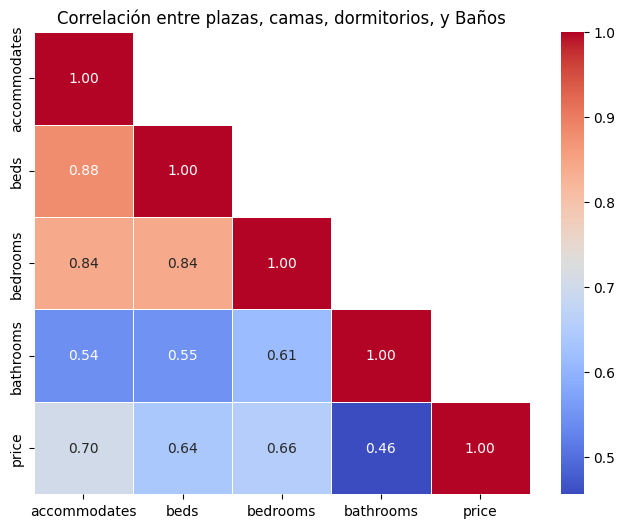

In [ ]:
# Selecciona las columnas numéricas de interés
correlation_columns = ['accommodates', 'beds', 'bedrooms', 'bathrooms','price']

# Calcula la matriz de correlación
corr_matrix = df_us[correlation_columns].corr(method='spearman')

# Crear una máscara para la parte superior triangular (sin la diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Tamaño del gráfico
plt.figure(figsize=(8, 6))

# Graficar el heatmap de correlación con la máscara
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Correlación entre plazas, camas, dormitorios, y Baños')
plt.show()

In [ ]:
#1- indice_satisfaccion
indice_satisfaccion = df_tourist['review_scores_rating'].sum() / df_tourist['apartment_id'].nunique()
print("Índice de satisfacción general:", round(indice_satisfaccion, 2))
print('\n')

#2 max(avg_scores)
columnas = ['review_scores_accuracy', 'review_scores_cleanliness',
            'review_scores_checkin', 'review_scores_communication',
            'review_scores_location']

avg_scores = df_tourist[columnas].mean().sort_values(ascending=False)
print("Ítem con mayor satisfacción promedio:")
print(avg_scores.round(2))

Índice de satisfacción general: 92.4


Ítem con mayor satisfacción promedio:
review_scores_communication    97.11
review_scores_checkin          96.99
review_scores_location         96.18
review_scores_accuracy         95.34
review_scores_cleanliness      93.89
dtype: float64


Media de puntuación por ciudad

In [147]:
media_pt_ciudad = df_us.groupby('city')['review_scores_rating'].agg('mean').round(2).reset_index()

media_pt_ciudad 

,city,review_scores_rating
0,barcelona,90.93
1,girona,92.01
2,madrid,93.06
3,malaga,92.21
4,mallorca,94.12
5,menorca,93.73
6,sevilla,93.88
7,valencia,92.31


In [99]:
#Porcentaje de alojamientos con una puntuación superior a 80 en cada ciudad
high_rating = df_tourist [df_tourist ['review_scores_rating'] > 80]
percent_high_rating = high_rating.groupby('city').size() / df.groupby('city').size() * 100
percent_high_rating = percent_high_rating.reset_index(name='percent_above_80')
percent_high_rating.round(2)

,city,percent_above_80
0,barcelona,85.90
1,girona,85.87
2,madrid,90.32
3,malaga,88.86
4,mallorca,89.34
5,menorca,92.20
6,sevilla,91.97
7,valencia,89.58


In [ ]:
media_pt_rt = df_us.groupby('room_type')['review_scores_rating'].agg('mean').round(2).reset_index()

media_pt_rt

,room_type,review_scores_rating
0,Entire home/apt,92.47
1,Hotel room,90.30
2,Private room,92.27
3,Shared room,91.64


In [ ]:
media_pt_rt_ciudad = df_us.groupby(['city','room_type'])['review_scores_rating'].agg('mean').round(2).reset_index()

media_pt_rt_ciudad

,city,room_type,review_scores_rating
0,barcelona,Entire home/apt,89.93
1,barcelona,Hotel room,94.43
2,barcelona,Private room,91.80
3,barcelona,Shared room,90.61
4,girona,Entire home/apt,92.00
5,girona,Hotel room,81.50
6,girona,Private room,93.06
7,madrid,Entire home/apt,93.04
8,madrid,Hotel room,90.90
9,madrid,Private room,93.17


In [101]:
# Procentaje alojamientos por ciudad y tipo de habitación
high_rating = df_us[df_us ['review_scores_rating'] > 80]
percent_high_rating = high_rating.groupby(['city','room_type']).size() / df_us.groupby(['city','room_type']).size() * 100
percent_high_rating = percent_high_rating.reset_index(name='percent_above_80')

round(percent_high_rating,2)

,city,room_type,percent_above_80
0,barcelona,Entire home/apt,87.05
1,barcelona,Hotel room,100.00
2,barcelona,Private room,91.65
3,barcelona,Shared room,88.89
4,girona,Entire home/apt,89.21
5,girona,Hotel room,50.00
6,girona,Private room,88.46
7,madrid,Entire home/apt,93.78
8,madrid,Hotel room,100.00
9,madrid,Private room,92.84


In [102]:
#Relación entre el tipo de alojamiento y la puntuación de satisfacción
df_us[['city', 'number_of_reviews']].groupby('city').sum().sort_values(by='number_of_reviews', ascending=False)

,number_of_reviews
city,
barcelona,80847
madrid,63566
sevilla,24170
mallorca,15756
valencia,15630
malaga,14898
girona,13597
menorca,1626


In [141]:
# Num. de reseñas:
print(df_us['number_of_reviews'].sum())

230090


In [142]:
import plotly.express as px
import pandas as pd

# Agrupamos por ciudad y sumamos el número de reseñas
reviews_per_city = df_us.groupby('city')['number_of_reviews'].sum().reset_index()

# Ordenamos por el número de reseñas (opcional, para que sea más fácil de visualizar)
reviews_per_city = reviews_per_city.sort_values(by='number_of_reviews', ascending=False)

# Creamos el gráfico de barras con Plotly, usando 'city' para el color
fig = px.bar(reviews_per_city, x='city', y='number_of_reviews', color='city',
             title='Número Total de Reseñas por Ciudad')
fig.update_layout(xaxis_title='Ciudad', yaxis_title='Número de Reseñas')

fig.update_layout(width=1000, height=400)

fig.show()

In [149]:
import plotly.express as px
import pandas as pd

# Suponiendo que media_pt_ciudad ya está definido y tiene las columnas 'city' y 'review_scores_rating'

fig = px.bar(
    media_pt_ciudad,
    x='city',
    y='review_scores_rating',
    color='city',  # Usamos la columna 'city' para asignar colores
    title='Media de puntuación por ciudad',
    labels={'review_scores_rating': 'Puntuación', 'city': 'Ciudad', 'city': 'Ciudad'}, # Se añade label para la leyenda de color
    height=600
)

# barras agrupadas
fig.update_layout(barmode='group',width=1000, height=400)

# Redimensionar el eje y
fig.update_yaxes(range=[88, 95])

fig.show()